Loading data...
Data loaded successfully from xmpp_prosody.csv and xmpp_ejabberd.csv

=== Basic RTT Analysis ===

Prosody Config RTT statistics:
count    5139.000000
mean      394.851819
std       300.643044
min         0.899000
25%       150.633000
50%       335.118000
75%       567.425000
max      1361.237000
Name: RTT_ms, dtype: float64

Ejabberd Config RTT statistics:
count    4970.000000
mean      435.672503
std       332.028277
min         0.943000
25%       172.925500
50%       368.894500
75%       620.214500
max      1706.734000
Name: RTT_ms, dtype: float64

=== Statistical Comparison ===

Comparison of RTT statistics:
       Prosody Config  Ejabberd Config  Difference %
count     5139.000000      4970.000000         -3.29
mean       394.851819       435.672503         10.34
std        300.643044       332.028277         10.44
min          0.899000         0.943000          4.89
25%        150.633000       172.925500         14.80
50%        335.118000       368.894500         

c:\Users\fccod\OneDrive\Documentos\GitHub\Work\Francoo86\MultiAgent-Benchmark\.venv\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 5139.
  res = hypotest_fun_out(*samples, **kwds)



Performing time series analysis...

Analyzing agent performance...

Sender Statistics for Prosody Config:
                    count        mean         std    min        25%       50%  \
Sender                                                                          
ACUÑA NAVARRO DANI   84.0  651.852274  389.111454  5.738  323.30150  659.6880   
ALBISTUR GONZALEZ    56.0  652.862839  396.455481  6.492  322.31150  643.2815   
ARAVENA APPELT HÉC   19.0  427.825158  262.388090  5.857  218.81900  428.4550   
ARAYA TORRES CARLO   14.0  299.089643  195.191511  1.287  145.59000  296.8510   
ARCE RAMOS CHRISTI   40.0  299.909450  188.561924  4.649  140.47650  299.2100   
...                   ...         ...         ...    ...        ...       ...   
VILCA ASTORGA BELF   11.0  107.782818   98.934334  2.493   25.84050  100.3020   
WONG BARREDA EDUAR  116.0  343.660198  221.331242  4.069  150.76700  332.1380   
YÁÑEZ MUÑOZ RICARD   98.0  297.149153  194.117328  3.734  141.99825  281.2355   
ZA

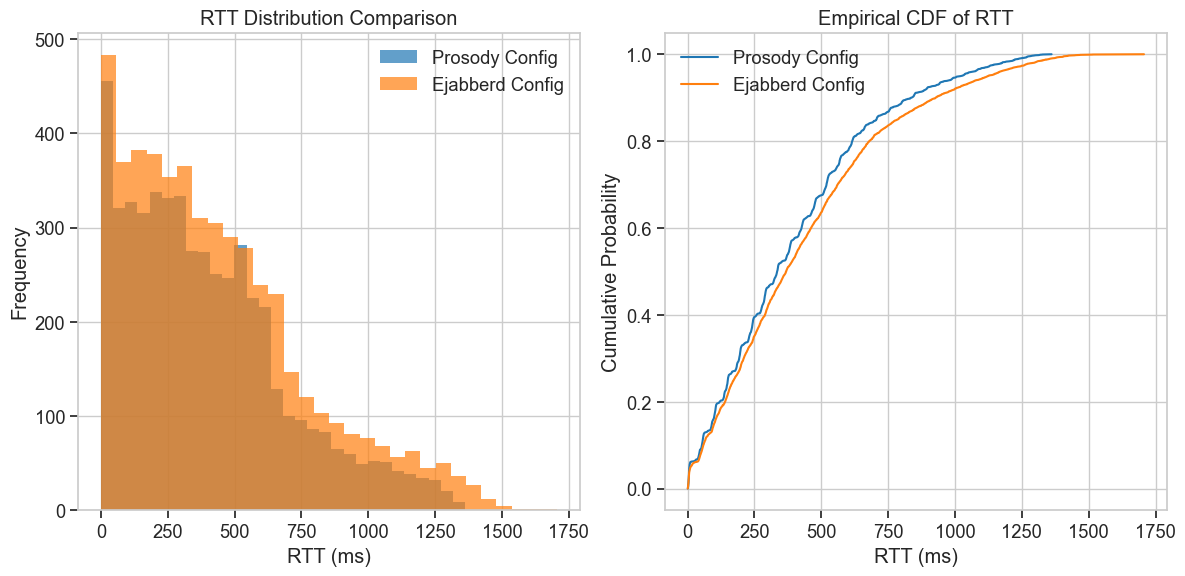

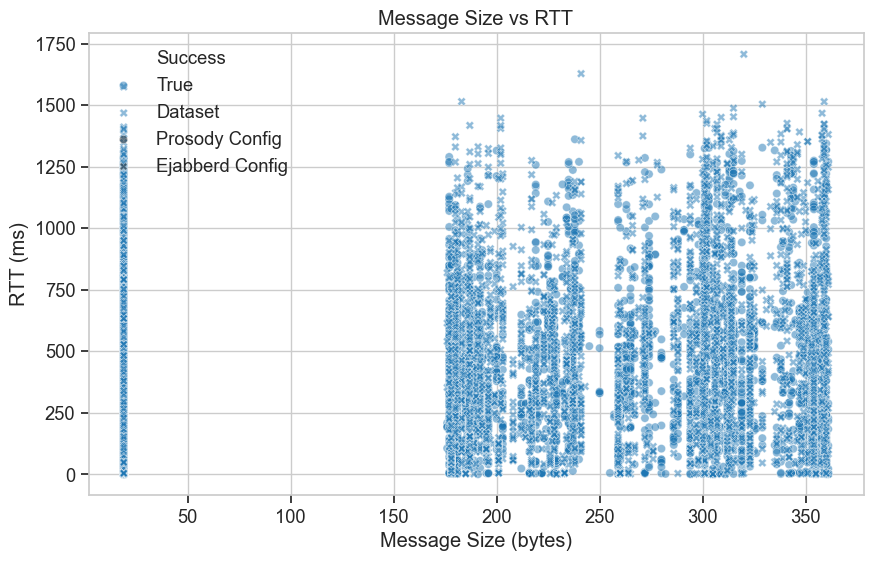

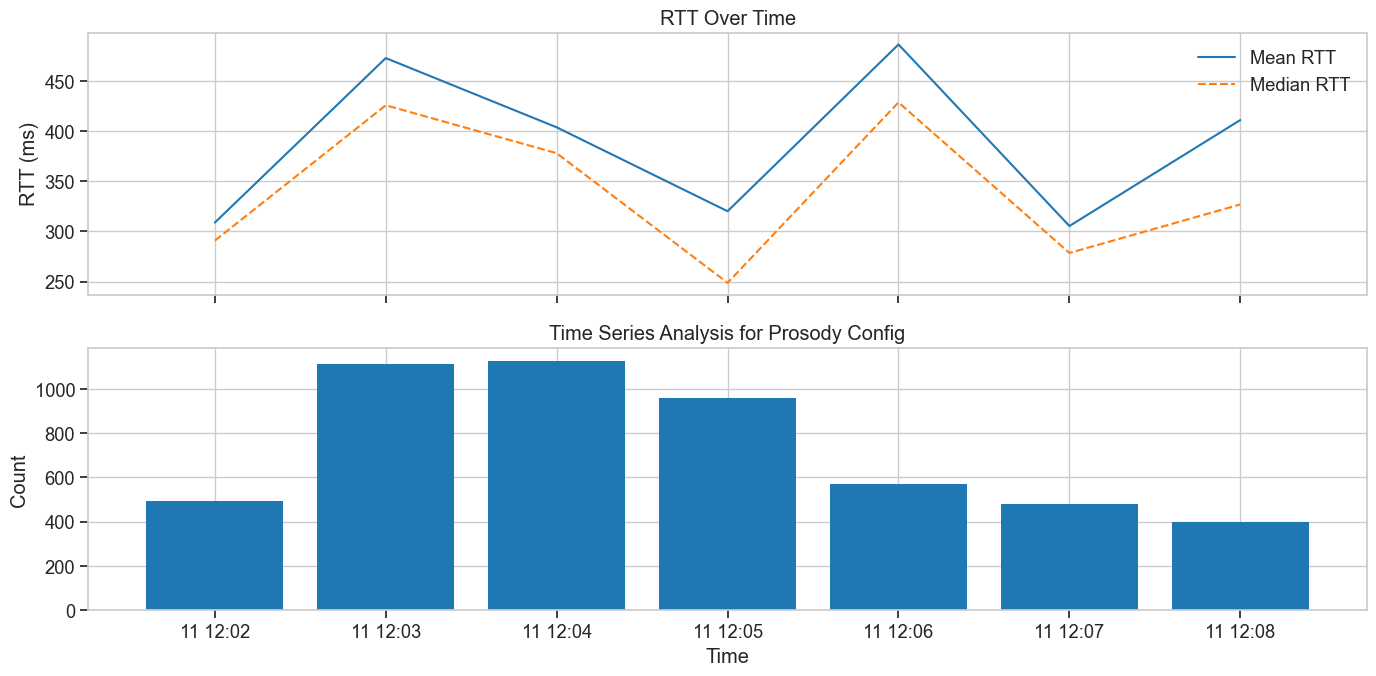

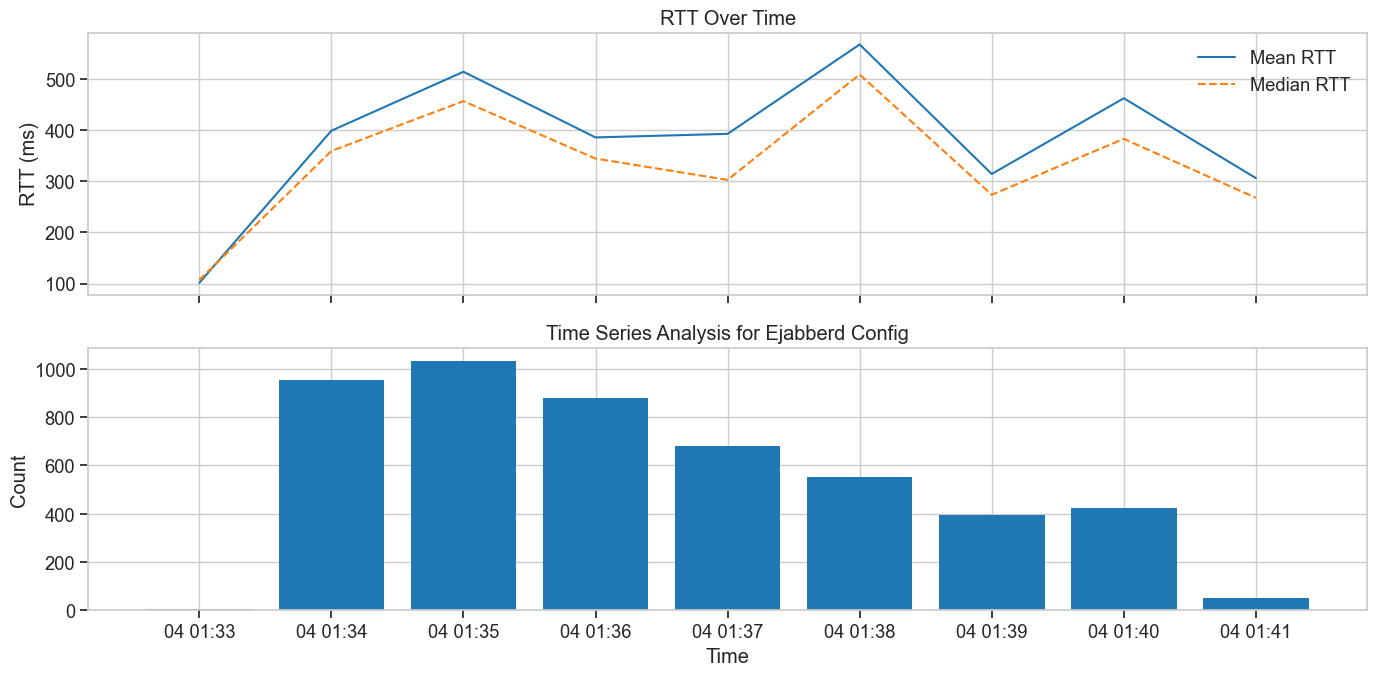

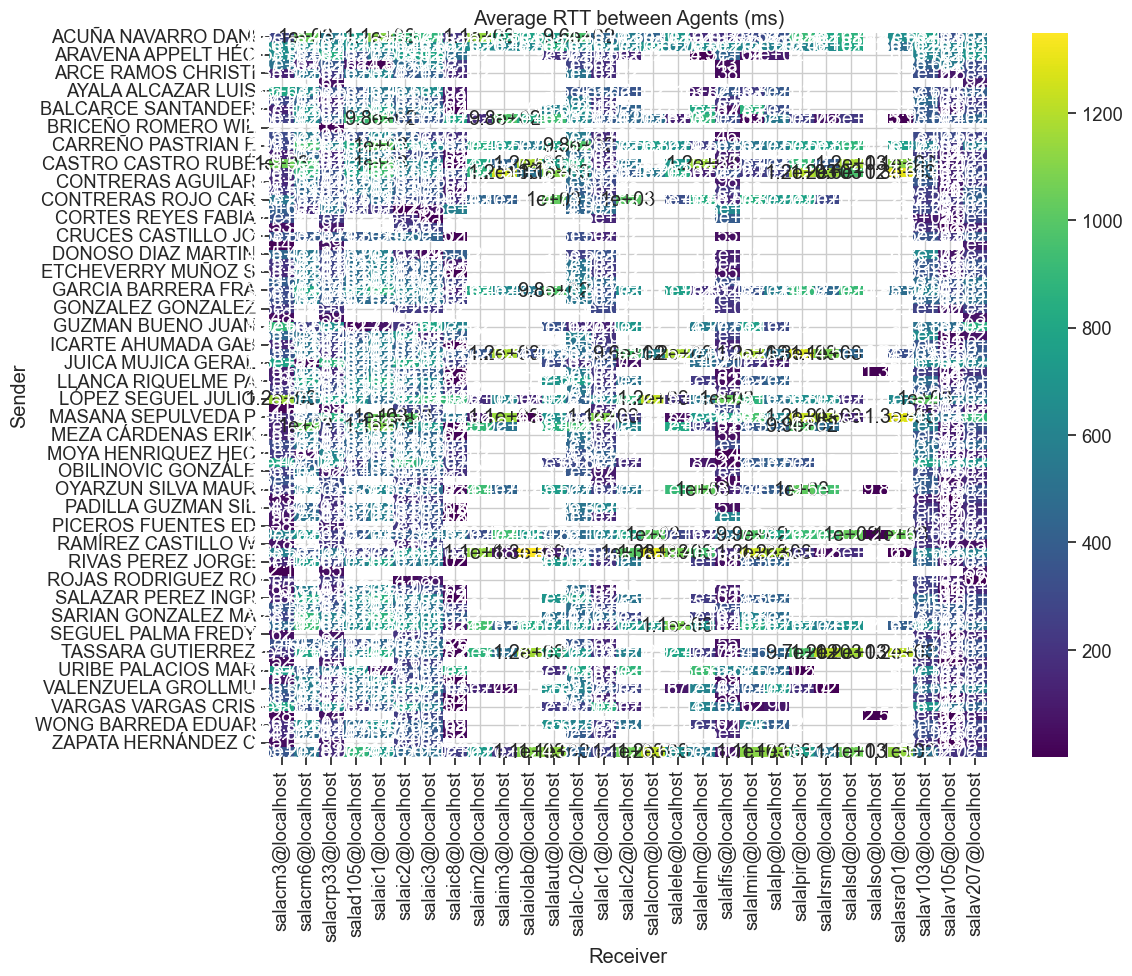

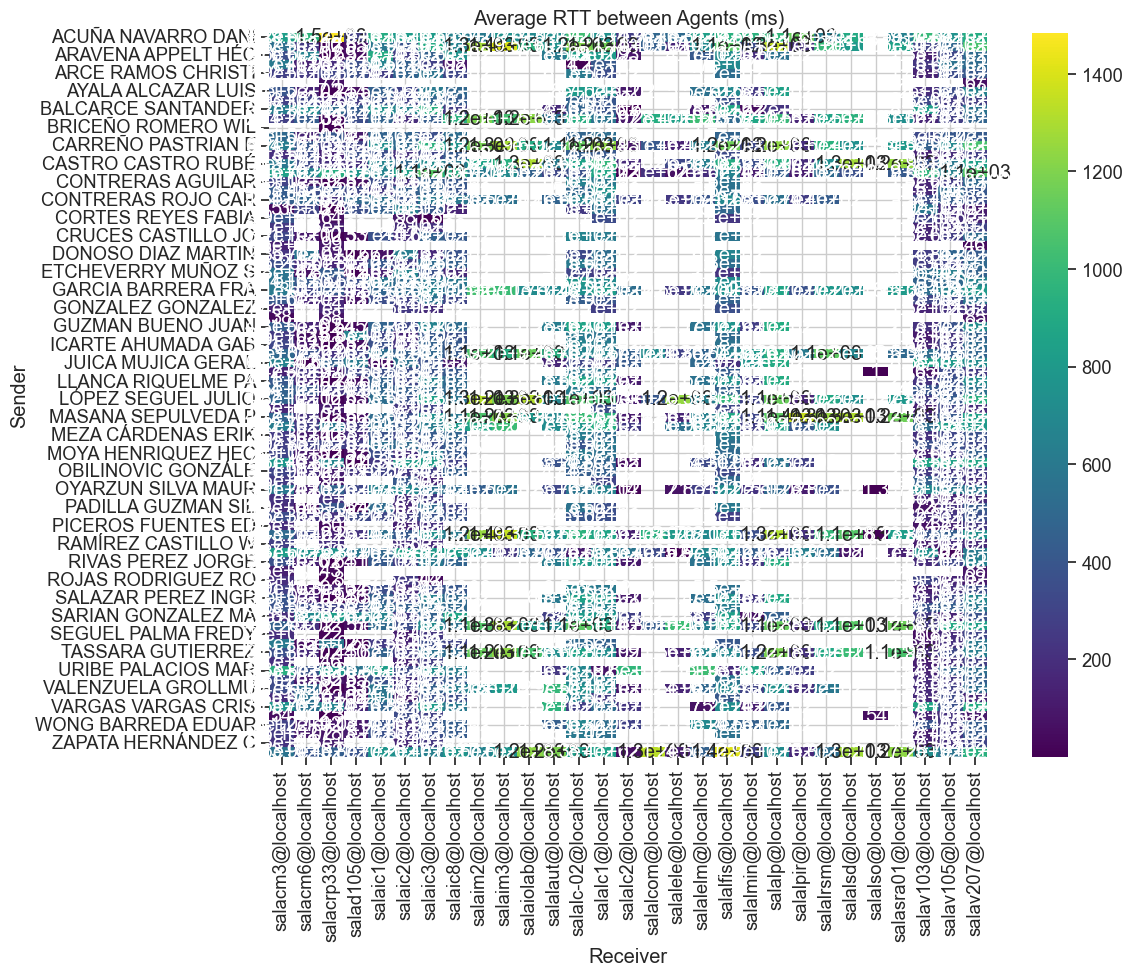

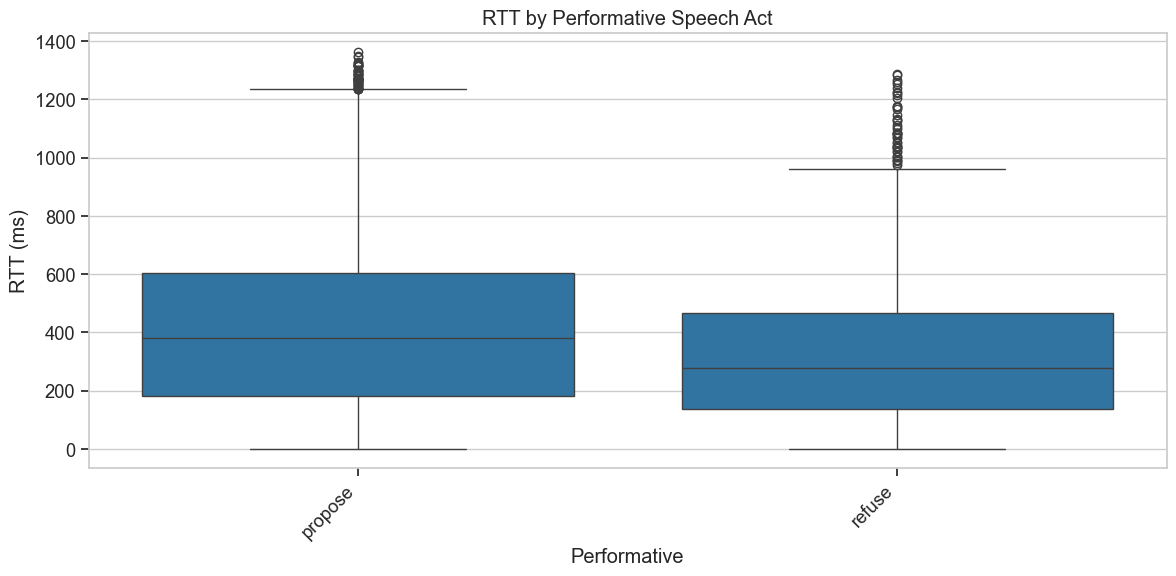

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import scipy.stats as stats

# Set the style for our plots
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("notebook", font_scale=1.2)

# 1. Data Loading Functions
def load_csv_data(filepath):
    """
    Load and parse the SPADE communication CSV data.
    Handle timestamp parsing and data type conversion.
    """
    try:
        # Read the CSV file
        df = pd.read_csv(filepath, parse_dates=['Timestamp'], encoding="latin-1")
        
        # If timestamp is not in datetime format, convert it
        if not pd.api.types.is_datetime64_dtype(df['Timestamp']):
            try:
                # Try common datetime formats
                df['Timestamp'] = pd.to_datetime(df['Timestamp'])
            except:
                print(f"Warning: Could not parse Timestamp column in {filepath}")
        
        # Convert numeric columns to appropriate types
        numeric_cols = ['RTT_ms', 'MessageSize_bytes']
        for col in numeric_cols:
            if col in df.columns:
                df[col] = pd.to_numeric(df[col], errors='coerce')
        
        # Convert boolean columns
        if 'Success' in df.columns:
            df['Success'] = df['Success'].astype(bool)
            
        return df
    except Exception as e:
        print(f"Error loading data from {filepath}: {e}")
        return None

# 2. Data Analysis Functions
def basic_stats(df, column='RTT_ms', group_by=None):
    """
    Calculate basic statistics for the specified column, optionally grouped by another column.
    """
    if group_by:
        return df.groupby(group_by)[column].describe()
    return df[column].describe()

def compare_rtt_stats(df1, df2, labels=None):
    """
    Compare RTT statistics between two dataframes.
    """
    if labels is None:
        labels = ['Dataset 1', 'Dataset 2']
    
    stats_df1 = df1['RTT_ms'].describe()
    stats_df2 = df2['RTT_ms'].describe()
    
    comparison_df = pd.DataFrame({
        labels[0]: stats_df1,
        labels[1]: stats_df2
    })
    
    # Calculate percentage difference
    comparison_df['Difference %'] = ((stats_df2 - stats_df1) / stats_df1 * 100).round(2)
    
    return comparison_df

def plot_rtt_distributions(df1, df2, labels=None, bins=30, figsize=(12, 6)):
    """
    Plot histograms of RTT distributions for visual comparison.
    """
    if labels is None:
        labels = ['Dataset 1', 'Dataset 2']
        
    fig, ax = plt.subplots(1, 2, figsize=figsize)
    
    # Plot histograms
    ax[0].hist(df1['RTT_ms'].dropna(), bins=bins, alpha=0.7, label=labels[0])
    ax[0].hist(df2['RTT_ms'].dropna(), bins=bins, alpha=0.7, label=labels[1])
    ax[0].set_title('RTT Distribution Comparison')
    ax[0].set_xlabel('RTT (ms)')
    ax[0].set_ylabel('Frequency')
    ax[0].legend()
    
    # Plot ECDFs for better comparison
    def ecdf(data):
        x = np.sort(data)
        y = np.arange(1, len(data) + 1) / len(data)
        return x, y
    
    x1, y1 = ecdf(df1['RTT_ms'].dropna())
    x2, y2 = ecdf(df2['RTT_ms'].dropna())
    
    ax[1].plot(x1, y1, label=labels[0])
    ax[1].plot(x2, y2, label=labels[1])
    ax[1].set_title('Empirical CDF of RTT')
    ax[1].set_xlabel('RTT (ms)')
    ax[1].set_ylabel('Cumulative Probability')
    ax[1].legend()
    
    plt.tight_layout()
    return fig

def plot_rtt_by_factor(df, factor_column, title=None, figsize=(12, 6)):
    """
    Plot RTT values grouped by a factor (e.g., Sender, Receiver, Performative).
    """
    if factor_column not in df.columns:
        print(f"Column {factor_column} not found in dataframe.")
        return None
    
    fig, ax = plt.subplots(figsize=figsize)
    
    # Create boxplot
    sns.boxplot(x=factor_column, y='RTT_ms', data=df, ax=ax)
    
    if title:
        ax.set_title(title)
    else:
        ax.set_title(f'RTT by {factor_column}')
    
    ax.set_xlabel(factor_column)
    ax.set_ylabel('RTT (ms)')
    
    # Rotate x-labels if there are many categories
    if len(df[factor_column].unique()) > 5:
        plt.xticks(rotation=45, ha='right')
    
    plt.tight_layout()
    return fig

def time_series_analysis(df, resample_rule='1min', figsize=(14, 7)):
    """
    Analyze RTT values over time.
    """
    # Ensure timestamp index
    df_ts = df.copy()
    if not isinstance(df_ts.index, pd.DatetimeIndex):
        df_ts.set_index('Timestamp', inplace=True)
    
    # Resample data
    rtt_mean = df_ts['RTT_ms'].resample(resample_rule).mean()
    rtt_median = df_ts['RTT_ms'].resample(resample_rule).median()
    rtt_count = df_ts['RTT_ms'].resample(resample_rule).count()
    
    # Plot results
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=figsize, sharex=True)
    
    # Plot RTT statistics
    ax1.plot(rtt_mean.index, rtt_mean, label='Mean RTT')
    ax1.plot(rtt_median.index, rtt_median, label='Median RTT', linestyle='--')
    ax1.set_title('RTT Over Time')
    ax1.set_ylabel('RTT (ms)')
    ax1.legend()
    
    # Plot message count
    ax2.bar(rtt_count.index, rtt_count, width=0.8*pd.Timedelta(resample_rule)/pd.Timedelta('1D'))
    ax2.set_title('Message Count Over Time')
    ax2.set_ylabel('Count')
    ax2.set_xlabel('Time')
    
    plt.tight_layout()
    return fig

def correlation_analysis(df):
    """
    Analyze correlations between RTT and other numeric variables.
    """
    # Select numeric columns
    numeric_df = df.select_dtypes(include=[np.number])
    
    # Calculate correlation matrix
    corr_matrix = numeric_df.corr()
    
    # Plot correlation heatmap
    fig, ax = plt.subplots(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, ax=ax)
    ax.set_title('Correlation Matrix')
    
    return corr_matrix, fig

def statistical_tests(df1, df2, column='RTT_ms'):
    """
    Perform statistical tests to compare RTT distributions.
    """
    results = {}
    
    # Check if data is normally distributed
    _, p_normal1 = stats.shapiro(df1[column].dropna())
    _, p_normal2 = stats.shapiro(df2[column].dropna())
    
    results['normality_test'] = {
        'dataset1_p_value': p_normal1,
        'dataset2_p_value': p_normal2,
        'is_normal': (p_normal1 > 0.05 and p_normal2 > 0.05)
    }
    
    # T-test (parametric)
    t_stat, p_t = stats.ttest_ind(df1[column].dropna(), df2[column].dropna(), equal_var=False)
    results['t_test'] = {
        't_statistic': t_stat,
        'p_value': p_t,
        'significant_difference': p_t < 0.05
    }
    
    # Mann-Whitney U test (non-parametric)
    u_stat, p_u = stats.mannwhitneyu(df1[column].dropna(), df2[column].dropna())
    results['mann_whitney_u'] = {
        'u_statistic': u_stat,
        'p_value': p_u,
        'significant_difference': p_u < 0.05
    }
    
    return results

# 3. Advanced Analysis Functions
def analyze_by_performative(df):
    """
    Analyze RTT by different performative speech acts.
    """
    if 'Performative' not in df.columns:
        print("No 'Performative' column found in the dataframe")
        return None
    
    # Group by performative
    perf_stats = df.groupby('Performative')['RTT_ms'].describe()
    
    # Plot
    fig, ax = plt.subplots(figsize=(12, 6))
    sns.boxplot(x='Performative', y='RTT_ms', data=df, ax=ax)
    ax.set_title('RTT by Performative Speech Act')
    ax.set_xlabel('Performative')
    ax.set_ylabel('RTT (ms)')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    
    return perf_stats, fig

def analyze_conversation_flow(df):
    """
    Analyze communication patterns within conversations.
    """
    if 'ConversationID' not in df.columns:
        print("No 'ConversationID' column found in the dataframe")
        return None
    
    # Basic stats by conversation
    conv_stats = df.groupby('ConversationID').agg({
        'RTT_ms': ['count', 'mean', 'median', 'std'],
        'MessageSize_bytes': ['mean', 'sum'],
        'Success': 'mean'  # Proportion of successful messages
    })
    
    # Plot conversation length vs avg RTT
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.scatterplot(
        x=conv_stats[('RTT_ms', 'count')], 
        y=conv_stats[('RTT_ms', 'mean')],
        size=conv_stats[('MessageSize_bytes', 'sum')],
        alpha=0.7,
        ax=ax
    )
    ax.set_title('Conversation Length vs. Average RTT')
    ax.set_xlabel('Number of Messages in Conversation')
    ax.set_ylabel('Average RTT (ms)')
    plt.tight_layout()
    
    return conv_stats, fig

def analyze_agent_performance(df):
    """
    Analyze performance characteristics of different agents.
    """
    if 'Sender' not in df.columns or 'Receiver' not in df.columns:
        print("Missing 'Sender' or 'Receiver' columns")
        return None
    
    # Sender stats
    sender_stats = df.groupby('Sender')['RTT_ms'].describe()
    
    # Receiver stats
    receiver_stats = df.groupby('Receiver')['RTT_ms'].describe()
    
    # Create heatmap of sender-receiver RTT
    pivot_df = df.pivot_table(
        index='Sender', 
        columns='Receiver', 
        values='RTT_ms',
        aggfunc='mean'
    )
    
    fig, ax = plt.subplots(figsize=(12, 10))
    sns.heatmap(pivot_df, annot=True, cmap='viridis', ax=ax)
    ax.set_title('Average RTT between Agents (ms)')
    plt.tight_layout()
    
    return {
        'sender_stats': sender_stats,
        'receiver_stats': receiver_stats,
        'interaction_matrix': pivot_df,
        'heatmap': fig
    }

# 4. Main Analysis Demo Section
# =============================

# Paths to your CSV files
file1_path = 'xmpp_prosody.csv'  # Replace with your file path
file2_path = 'xmpp_ejabberd.csv' # Replace with your file path

# Custom labels for your datasets
dataset1_label = 'Prosody Config'  # Replace with your first configuration name
dataset2_label = 'Ejabberd Config'  # Replace with your second configuration name

# Load the data
print("Loading data...")

# Replace these blocks with your actual data loading when ready
# For now, we'll create placeholders for demonstration purposes
try:
    # Try to load real files if they exist
    df1 = load_csv_data(file1_path)
    df2 = load_csv_data(file2_path)
    print(f"Data loaded successfully from {file1_path} and {file2_path}")
except:
    print("Creating placeholder data for demonstration")
    # Create sample data for demonstration
    np.random.seed(42)
    
    # Generate timestamps
    base_time = pd.Timestamp('2023-01-01')
    timestamps1 = [base_time + pd.Timedelta(seconds=i*5) for i in range(1000)]
    timestamps2 = [base_time + pd.Timedelta(seconds=i*5) for i in range(1000)]
    
    # Sample SPADE agents
    agents = ['agent1@localhost', 'agent2@localhost', 'agent3@localhost', 
              'agent4@localhost', 'agent5@localhost']
    
    # Sample performatives (from FIPA ACL)
    performatives = ['INFORM', 'REQUEST', 'AGREE', 'REFUSE', 'QUERY', 'PROPOSE']
    
    # Generate conversation IDs
    conv_ids = [f'conv_{i}' for i in range(1, 51)]
    
    # Generate sample dataframes
    df1 = pd.DataFrame({
        'Timestamp': timestamps1,
        'Sender': np.random.choice(agents, 1000),
        'Receiver': np.random.choice(agents, 1000),
        'ConversationID': np.random.choice(conv_ids, 1000),
        'Performative': np.random.choice(performatives, 1000),
        'RTT_ms': np.random.gamma(shape=2.0, scale=10.0, size=1000),  # First distribution
        'MessageSize_bytes': np.random.randint(100, 5000, 1000),
        'Success': np.random.choice([True, False], 1000, p=[0.95, 0.05]),
        'AdditionalInfo': [''] * 1000,
        'Ontology': np.random.choice(['ontology1', 'ontology2'], 1000)
    })
    
    df2 = pd.DataFrame({
        'Timestamp': timestamps2,
        'Sender': np.random.choice(agents, 1000),
        'Receiver': np.random.choice(agents, 1000),
        'ConversationID': np.random.choice(conv_ids, 1000),
        'Performative': np.random.choice(performatives, 1000),
        'RTT_ms': np.random.gamma(shape=1.5, scale=15.0, size=1000),  # Second distribution
        'MessageSize_bytes': np.random.randint(100, 5000, 1000),
        'Success': np.random.choice([True, False], 1000, p=[0.92, 0.08]),
        'AdditionalInfo': [''] * 1000,
        'Ontology': np.random.choice(['ontology1', 'ontology2'], 1000)
    })

# Now we're ready to analyze the data
# ===================================

# 5. Basic Analysis
print("\n=== Basic RTT Analysis ===")
basic_stats_df1 = basic_stats(df1)
basic_stats_df2 = basic_stats(df2)

print(f"\n{dataset1_label} RTT statistics:")
print(basic_stats_df1)

print(f"\n{dataset2_label} RTT statistics:")
print(basic_stats_df2)

# 6. Statistical Comparison
print("\n=== Statistical Comparison ===")
comparison_stats = compare_rtt_stats(df1, df2, labels=[dataset1_label, dataset2_label])
print("\nComparison of RTT statistics:")
print(comparison_stats)

# 7. Run Statistical Tests
print("\n=== Statistical Tests ===")
test_results = statistical_tests(df1, df2)
print("\nNormality Test Results:")
print(f"Dataset 1 p-value: {test_results['normality_test']['dataset1_p_value']:.4f}")
print(f"Dataset 2 p-value: {test_results['normality_test']['dataset2_p_value']:.4f}")
print(f"Data normally distributed: {test_results['normality_test']['is_normal']}")

print("\nT-test Results:")
print(f"T-Statistic: {test_results['t_test']['t_statistic']:.4f}")
print(f"P-value: {test_results['t_test']['p_value']:.4f}")
print(f"Significant difference: {test_results['t_test']['significant_difference']}")

print("\nMann-Whitney U Test Results:")
print(f"U-Statistic: {test_results['mann_whitney_u']['u_statistic']:.4f}")
print(f"P-value: {test_results['mann_whitney_u']['p_value']:.4f}")
print(f"Significant difference: {test_results['mann_whitney_u']['significant_difference']}")

# 8. Visual Comparisons
print("\n=== Generating Visualizations ===")
print("Plotting RTT distributions...")
plot_rtt_distributions(df1, df2, labels=[dataset1_label, dataset2_label])

# 9. Message Size vs RTT Analysis
print("\nAnalyzing Message Size vs RTT correlation...")
fig, ax = plt.subplots(figsize=(10, 6))
sns.scatterplot(x='MessageSize_bytes', y='RTT_ms', hue='Success', 
                data=pd.concat([
                    df1.assign(Dataset=dataset1_label), 
                    df2.assign(Dataset=dataset2_label)
                ]), 
                style='Dataset', alpha=0.5, ax=ax)
ax.set_title('Message Size vs RTT')
ax.set_xlabel('Message Size (bytes)')
ax.set_ylabel('RTT (ms)')

# 10. Time Series Analysis
print("\nPerforming time series analysis...")
time_series_analysis(df1, resample_rule='1min')
plt.title(f'Time Series Analysis for {dataset1_label}')

time_series_analysis(df2, resample_rule='1min')
plt.title(f'Time Series Analysis for {dataset2_label}')

# 11. Agent Performance Analysis
print("\nAnalyzing agent performance...")
agent_perf1 = analyze_agent_performance(df1)
print(f"\nSender Statistics for {dataset1_label}:")
if agent_perf1:
    print(agent_perf1['sender_stats'])

agent_perf2 = analyze_agent_performance(df2)
print(f"\nSender Statistics for {dataset2_label}:")
if agent_perf2:
    print(agent_perf2['sender_stats'])

# 12. SPADE-specific Analysis
print("\nPerforming SPADE-specific analysis...")
# Performative analysis
perf_stats1, _ = analyze_by_performative(df1)
print(f"\nPerformative Statistics for {dataset1_label}:")
print(perf_stats1)

# 13. Conclusion
print("\n=== Analysis Complete ===")
print(f"The comparison between {dataset1_label} and {dataset2_label} shows:")

# Print main findings
mean_diff = ((df2['RTT_ms'].mean() - df1['RTT_ms'].mean()) / df1['RTT_ms'].mean() * 100)
median_diff = ((df2['RTT_ms'].median() - df1['RTT_ms'].median()) / df1['RTT_ms'].median() * 100)

print(f"- Mean RTT difference: {mean_diff:.2f}%")
print(f"- Median RTT difference: {median_diff:.2f}%")

if test_results['t_test']['significant_difference']:
    print("- The RTT differences are statistically significant.")
else:
    print("- The RTT differences are not statistically significant.")

print("\nRecommendation:")
if df1['RTT_ms'].mean() < df2['RTT_ms'].mean():
    print(f"Based on RTT performance, {dataset1_label} appears to be more efficient.")
else:
    print(f"Based on RTT performance, {dataset2_label} appears to be more efficient.")

# Show all plots
plt.show()